<a href="https://colab.research.google.com/github/NikkiSatmaka/ets-on-carbon-emission/blob/main/co2_gdp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction

Jakarta Satu

2022 UN Big Data Hackathon

## Theme
Carbon Emissions and Emissions Trading System (ETS)

### Objective
- Find out which nations implements ETS
- Find out the mean of the Carbon Emissions normalized between each nations

### Problem Statement
- Does ETS implementation have a significant impact on carbon emissions?

## Prepare Environment

In [1]:
# google auth credentials
from google.colab import auth
from google.auth import default
import gspread

auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)


In [2]:
# install prophet for timeseries prediction
!python -m pip install --quiet prophet

# 2. Importing Libraries

In [3]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

from gspread_dataframe import get_as_dataframe, set_with_dataframe

from scipy import stats
from sklearn.preprocessing import minmax_scale

from prophet import Prophet
from prophet.plot import plot
# # Evaluate Classification Models
# from sklearn.metrics import classification_report

# # Useful functions
# from packages.checker import check_missing
# from packages.checker import check_links_only
# from packages.visualization import plot_loss, plot_acc
# from packages.imputation_handling import drop_missing_news

# from packages.text_preprocessing import combine_text
# from packages.text_preprocessing import clean_text
# from packages.text_preprocessing import lemmatize_text


pd.set_option('display.precision', 2)

sns.set_theme(style='darkgrid', palette='Set1')

# set random seed for reproducibility
np.random.seed(42)

%matplotlib inline

### Custom function

In [4]:
def tidy_cols(dataframe):
    """
    Tidy up column names by replacing space with underscore
    and making everything lower case
    """
    return [x.lower().replace(' ', '_') for x in dataframe.columns]

def create_timeseries(dataframe):
    """
    Create timeseries data
    """
    output = dataframe[['country_name', 'year', 'co2_per_gdp']].pivot(
        index='year',
        columns='country_name',
        values='co2_per_gdp'
    )
    output.index.name = None
    output.columns.name = None
    return output


def to_sheets(dataframe, sheet, name, use_index=True):
    """
    Save to google sheets
    """
    try:
        sheet.add_worksheet(title=name, rows=100, cols=20)
    except gspread.exceptions.APIError as e:
        pass
    finally:
        new_worksheet = sheet.worksheet(name)
        new_worksheet.clear()
        set_with_dataframe(new_worksheet, dataframe, include_index=use_index)

def end_of_year(datetime):
    """
    Return the end of year given the date
    """
    return datetime.replace(month=12, day=31)


# 3. Start

## Data Preparation

In [5]:
# google sheet urls
co2_gsheets_url = "https://docs.google.com/spreadsheets/d/10KgeIF3Zyfg7cErQoWHsJnLYb2hnpo9SXp-VAJIqcq8"
gdp_gsheets_url = "https://docs.google.com/spreadsheets/d/1yaMeIK9G6RnFOtOfL1iwk0wn4NCG6oawzagYh-6kyRA"
country_code_url = "https://docs.google.com/spreadsheets/d/1Vy68ZBVLRHgNpkoVWBrDjby8GCyZFMRX_PHXpDd05k4"
output_url = "https://docs.google.com/spreadsheets/d/1PKTrK7g_YmcjrzWoKyOV17b5OMSJMrmpPuvn3a02jRw"

# read data and put it in a dataframe
co2_sheet = gc.open_by_url(co2_gsheets_url)
gdp_sheet = gc.open_by_url(gdp_gsheets_url)
country_code_sheet = gc.open_by_url(country_code_url)
output_sheet = gc.open_by_url(output_url)

# get google sheet values
co2 = co2_sheet.worksheet('data_copy').get_all_values()
gdp = gdp_sheet.worksheet('data_copy').get_all_values()
ets_info = co2_sheet.worksheet('ets_members').get_all_values()
country_code = country_code_sheet.worksheet('code').get_all_values()

# create filters
filter_year = [str(_) for _ in list(range(1990, 2020))]
filter_country_code = pd.DataFrame(country_code[1:], columns=country_code[0])['ISO3']
filter_country_name = pd.DataFrame(country_code[1:], columns=country_code[0])['COUNTRY']
filter_type = ['ETS']
filter_ets_status = ['Implemented']
filter_indicators = ['indicator_name', 'indicator_code']

# make dataframe
df_co2 = pd.DataFrame(co2[4:], columns=co2[3])
df_gdp = pd.DataFrame(gdp[4:], columns=gdp[3])
df_ets = pd.DataFrame(ets_info[4:], columns=ets_info[3])

# adjust column names
df_co2.columns = tidy_cols(df_co2)
df_gdp.columns = tidy_cols(df_gdp)
df_ets.columns = tidy_cols(df_ets)

# filter data
df_co2 = df_co2[df_co2['country_code'].isin(filter_country_code)]
df_gdp = df_gdp[df_gdp['country_code'].isin(filter_country_code)]

# finalize dataframe
df_co2 = pd.concat([df_co2.iloc[:, :4], df_co2[filter_year]], axis=1)
df_gdp = pd.concat([df_gdp.iloc[:, :4], df_gdp[filter_year]], axis=1)

In [6]:
# melt dataframe
df_co2_melt = df_co2.melt(
    id_vars=['country_name', 'country_code', 'indicator_name', 'indicator_code'],
    var_name='year',
    value_name='co2'
)

df_gdp_melt = df_gdp.melt(
    id_vars=['country_name', 'country_code', 'indicator_name', 'indicator_code'],
    var_name='year',
    value_name='gdp'
)

# convert object to numbers and datetime
df_co2_melt['co2'] = pd.to_numeric(df_co2_melt['co2'], errors='coerce')
df_gdp_melt['gdp'] = pd.to_numeric(df_gdp_melt['gdp'], errors='coerce')
df_co2_melt['year'] = pd.to_datetime(df_co2_melt['year'], errors='coerce').apply(end_of_year)
df_gdp_melt['year'] = pd.to_datetime(df_gdp_melt['year'], errors='coerce').apply(end_of_year)
df_ets['implementation_year'] = pd.to_datetime(df_ets['implementation_year'], errors='coerce')

In [7]:
# merge co2 and gdp
df_co2_gdp = df_co2_melt.drop(filter_indicators, axis=1).merge(
    df_gdp_melt.drop(filter_indicators, axis=1),
    on=['country_name', 'country_code', 'year'],
    suffixes=['_co2', '_gdp']
)

# calculate co2 per gdp
df_co2_gdp['co2_per_gdp'] = df_co2_gdp['co2'] / df_co2_gdp['gdp']

# calculate co2 and gdp proportion for the particular year
df_co2_gdp['co2_proportion'] = df_co2_gdp['co2'] / df_co2_gdp.groupby('year')['co2'].transform('sum')
df_co2_gdp['gdp_proportion'] = df_co2_gdp['gdp'] / df_co2_gdp.groupby('year')['gdp'].transform('sum')

Since Carbon Emission values and worth differs between each nations, we decided to normalize it by dividing it with the nations' GDP

In [8]:
# merge co2 data with ets info
df_co2_ets = df_co2_gdp.merge(
    df_ets,
    how='left',
    on=['country_name', 'country_code'],
    suffixes=['_value', '_ets']
)

In [9]:
# create filter for ets use
filter_uses_ets = (df_co2_ets['implementation_year'] < df_co2_ets['year'].max())

# create a column for use_ets status
df_co2_ets['use_ets'] = filter_uses_ets

In [10]:
# separate those who implement ets into each dataframe
df_use_ets = df_co2_ets[filter_uses_ets]
df_no_ets = df_co2_ets[~filter_uses_ets]

# create timeseries data
df_use_ets_ts = create_timeseries(df_use_ets)
df_no_ets_ts = create_timeseries(df_no_ets)

In [11]:
# normalize timeseries data to compare
# We also filter the data to start from 1999 to 2019, so we have 20 data points
# of percent change
df_ets_mean_ts = pd.DataFrame(
    list(zip(
        df_use_ets_ts['1999-01-01':].mean(axis=1),
        df_no_ets_ts['1999-01-01':].mean(axis=1)
    )),
    index=df_use_ets_ts['1999-01-01':].index,
    columns=['use_ets', 'no_ets']
)
df_ets_mean_ts.index.name = None

# calculate percent change of CO2/GDP each year
df_ets_mean_ts['use_ets_pct'] = df_ets_mean_ts['use_ets'].pct_change()
df_ets_mean_ts['no_ets_pct'] = df_ets_mean_ts['no_ets'].pct_change()

#### Checkpoint - Save to google sheets

In [12]:
# save dataframe to google sheets
to_sheets(df_co2_ets, output_sheet, 'co2_ets')
to_sheets(df_use_ets_ts, output_sheet, 'use_ets_ts')
to_sheets(df_no_ets_ts, output_sheet, 'no_ets_ts')
to_sheets(df_ets_mean_ts, output_sheet, 'ets_mean_ts')

# Exploratory Data Analysis

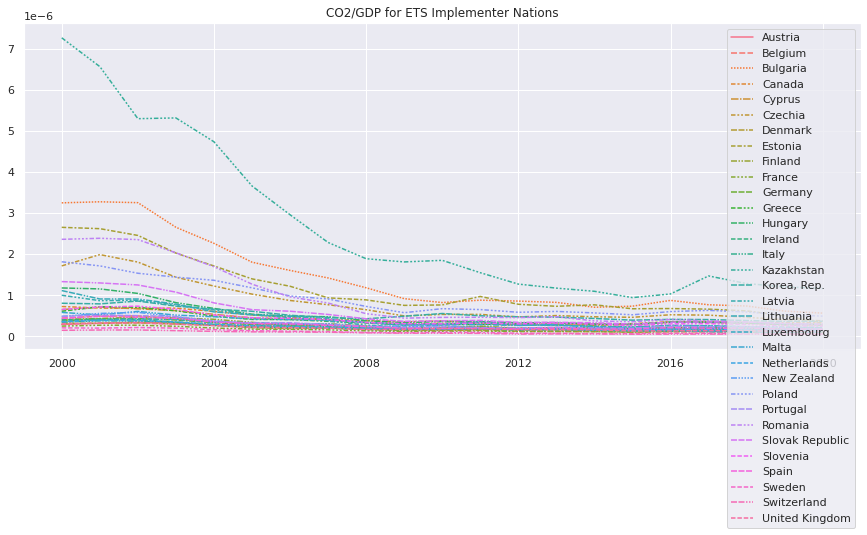

In [13]:
# compare timeseries data for ETS implementers
plt.figure(figsize=(15, 6))
sns.lineplot(data=df_use_ets_ts['1999-01-01':])
plt.title(f'CO2/GDP for ETS Implementer Nations')
plt.show()

We can see that Kazakhstan has a higher carbon emissions than the rest of ETS implementers, but they seem to be on the way to converge

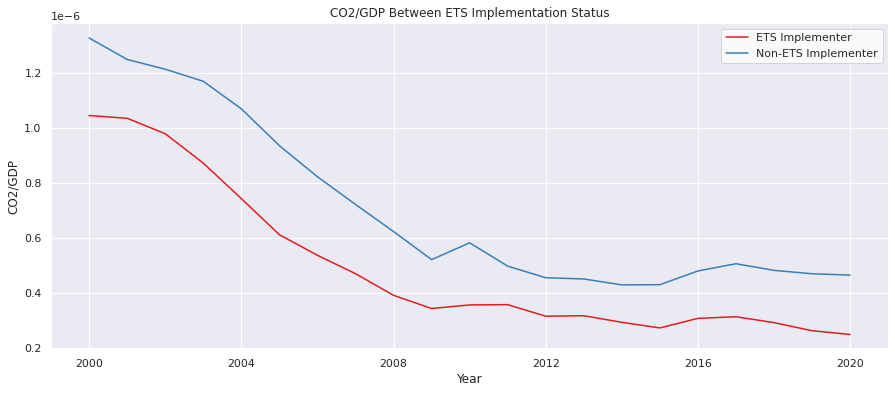

In [14]:
# compare timeseries data
plt.figure(figsize=(15, 6))
sns.lineplot(data=df_ets_mean_ts['use_ets'])
sns.lineplot(data=df_ets_mean_ts['no_ets'])
plt.title(f'CO2/GDP Between ETS Implementation Status')
plt.xlabel('Year')
plt.ylabel('CO2/GDP')
plt.legend(labels=['ETS Implementer','Non-ETS Implementer'], facecolor='white')
plt.show()


We can see that carbon emissions tend to be lower for those which implement ETS. However, since their starting point is already lower, that doesn't mean it was caused by the ETS itself.
We also do not see any major difference between the slope of the decrease in CO2/GDP

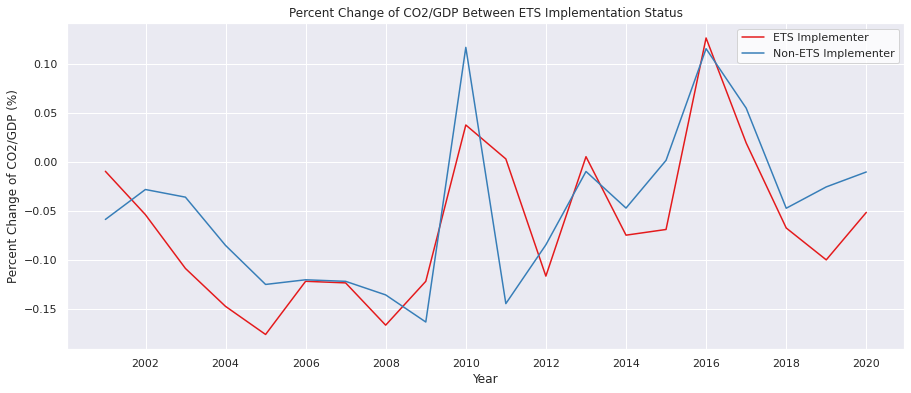

In [15]:
# compare percent change
plt.figure(figsize=(15, 6))
sns.lineplot(data=df_ets_mean_ts['use_ets_pct'][1:])
sns.lineplot(data=df_ets_mean_ts['no_ets_pct'][1:])
plt.title(f'Percent Change of CO2/GDP Between ETS Implementation Status')
plt.xlabel('Year')
plt.ylabel('Percent Change of CO2/GDP (%)')
plt.legend(labels=['ETS Implementer','Non-ETS Implementer'], facecolor='white')
plt.show()

We can see that there doesn't seem to be a conformable difference between each plot. Therefore, we are going to perform hypothesis testing on this percent change data to see whether ETS really has an impact on carbon emissions

# Hypothesis Testing

We want to check, whether the average of percent change significantly differs betweeen those nations which implement ETS and those that do not. For this, we use hypothesis testing using two sample independent two tailed test

$H_{0}: \mu_{percent\ change\ use\ ETS} = \mu_{percent\ change\ no\ ETS}$\
$H_{1}: \mu_{percent\ change\ use\ ETS} \neq \mu_{percent\ change\ no\ ETS}$

In [16]:
print(f"Average of percent change of CO2/GDP for ETS implementer: {df_ets_mean_ts['use_ets_pct'][1:].mean():.2f}")
print(f"Average of percent change of CO2/GDP for Non-ETS implementer: {df_ets_mean_ts['no_ets_pct'][1:].mean():.2f}")

Average of percent change of CO2/GDP for ETS implementer: -0.07
Average of percent change of CO2/GDP for Non-ETS implementer: -0.05


In [17]:
ci_use_ets = stats.norm.interval(
    0.95,
    df_ets_mean_ts['use_ets_pct'][1:].mean(),
    df_ets_mean_ts['use_ets_pct'][1:].std()
)
ci_no_ets = stats.norm.interval(
    0.95,
    df_ets_mean_ts['no_ets_pct'][1:].mean(),
    df_ets_mean_ts['no_ets_pct'][1:].std()
)
print(f'The confidence intervals from ETS implementer is between {ci_use_ets[0]:.2f} and {ci_use_ets[1]:.2f}')
print(f'The confidence intervals from Non-ETS implementer is between {ci_no_ets[0]:.2f} and {ci_no_ets[1]:.2f}')


The confidence intervals from ETS implementer is between -0.22 and 0.08
The confidence intervals from Non-ETS implementer is between -0.20 and 0.11


In [18]:
t_stat, p_val = stats.ttest_ind(
    df_ets_mean_ts['use_ets_pct'][1:],
    df_ets_mean_ts['no_ets_pct'][1:]
)
print('p-value:', p_val)
print('t-statistics:',t_stat)

p-value: 0.4693683602597868
t-statistics: -0.7308252079260366


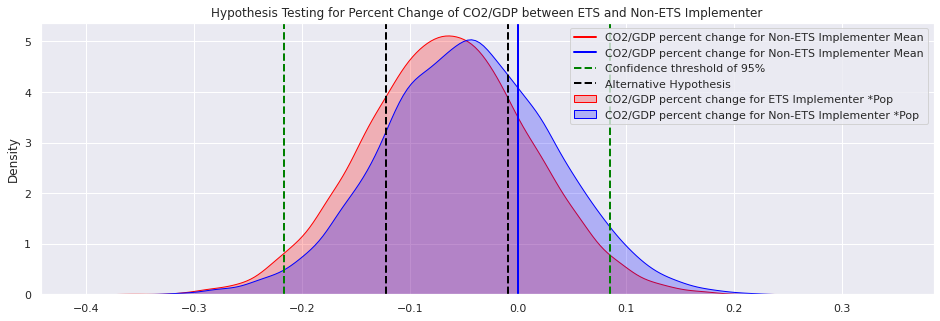

In [19]:
use_ets_pop = np.random.normal(
    df_ets_mean_ts['use_ets_pct'][1:].mean(),
    df_ets_mean_ts['use_ets_pct'][1:].std(),
    10000
)
no_ets_pop = np.random.normal(
    df_ets_mean_ts['no_ets_pct'][1:].mean(),
    df_ets_mean_ts['no_ets_pct'][1:].std(),
    10000
)

plt.figure(figsize=(16, 5))
sns.kdeplot(
    use_ets_pop,
    label='CO2/GDP percent change for ETS Implementer *Pop',
    color='red',
    shade=True
)
sns.kdeplot(
    no_ets_pop,
    label='CO2/GDP percent change for Non-ETS Implementer *Pop',
    color='blue',
    shade=True
)

plt.axvline(
    df_ets_mean_ts['use_ets'].mean(),
    color='red',
    linewidth=2,
    label='CO2/GDP percent change for Non-ETS Implementer Mean'
)
plt.axvline(
    df_ets_mean_ts['no_ets'].mean(),
    color='blue',
    linewidth=2,
    label='CO2/GDP percent change for Non-ETS Implementer Mean'
)

plt.axvline(ci_use_ets[1], color='green', linestyle='dashed', linewidth=2, label='Confidence threshold of 95%')
plt.axvline(ci_use_ets[0], color='green', linestyle='dashed', linewidth=2)

plt.axvline(use_ets_pop.mean() + t_stat*use_ets_pop.std(), color='black', linestyle='dashed', linewidth=2, label='Alternative Hypothesis')
plt.axvline(use_ets_pop.mean() - t_stat*use_ets_pop.std(), color='black', linestyle='dashed', linewidth=2)

plt.title('Hypothesis Testing for Percent Change of CO2/GDP between ETS and Non-ETS Implementer')
plt.legend()
plt.show()

*Based on the result above, having a p value of more than `0.05`*, we can conclude that we fail to reject the null hypothesis, which means there are no significant difference in percent change of CO2/GDP between ETS implementers and Non-ETS implementers

# Time Series Prediction
Create time series prediction on CO2/GDP

In [20]:
train_size = 15  # 15 data points as training set
val_size = 5  # 5 data points as validation set
train_val_size = train_size + val_size  # size of train+validation set
i = train_val_size  # data points to forecast
H = 10  # forecast horizon

# create dataframe for prediction
df_use_ets_prophet = df_ets_mean_ts['use_ets'].reset_index()
df_use_ets_prophet.columns = ['ds', 'y']
df_no_ets_prophet = df_ets_mean_ts['no_ets'].reset_index()
df_no_ets_prophet.columns = ['ds', 'y']

# set up cap and floor
prophet_cap = 1.5e-6
prophet_floor = 0.1e-6

df_use_ets_prophet['cap'] = prophet_cap
df_use_ets_prophet['floor'] = prophet_floor
df_no_ets_prophet['cap'] = prophet_cap
df_no_ets_prophet['floor'] = prophet_floor

# Fit prophet model
m_use_ets = Prophet(growth='logistic')
m_use_ets.fit(df_use_ets_prophet[i-train_val_size:i])
m_no_ets = Prophet(growth='logistic')
m_no_ets.fit(df_no_ets_prophet[i-train_val_size:i])

# Create dataframe with the dates we want to predict
future_use_ets = m_use_ets.make_future_dataframe(periods=H, freq='Y')
future_no_ets = m_no_ets.make_future_dataframe(periods=H, freq='Y')

# future cap and floor
future_use_ets['cap'] = prophet_cap
future_use_ets['floor'] = 0.1e-6
future_no_ets['cap'] =  prophet_cap
future_no_ets['floor'] = 0.1e-6

# Predict
forecast_use_ets = m_use_ets.predict(future_use_ets)
forecast_no_ets = m_no_ets.predict(future_no_ets)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcqhsxfmk/hajr6inu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcqhsxfmk/rrj9gf2v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58394', 'data', 'file=/tmp/tmpcqhsxfmk/hajr6inu.json', 'init=/tmp/tmpcqhsxfmk/rrj9gf2v.json', 'output', 'file=/tmp/tmpcqhsxfmk/prophet_modelkkgmeuox/prophet_model-20221111054524.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:45:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:45:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

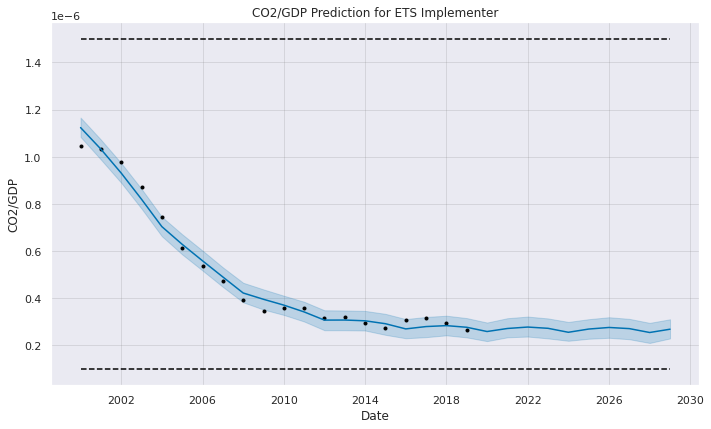

In [21]:
fig_use_ets = m_use_ets.plot(forecast_use_ets, xlabel='Date', ylabel='CO2/GDP')
ax_use_ets = fig_use_ets.gca()
ax_use_ets.set_title("CO2/GDP Prediction for ETS Implementer")
# ax.set_xlabel("X", size=34)
# ax.set_ylabel("Y", size=34)
# ax.tick_params(axis="x", labelsize=24)
# ax.tick_params(axis="y", labelsize=24)
plt.show()

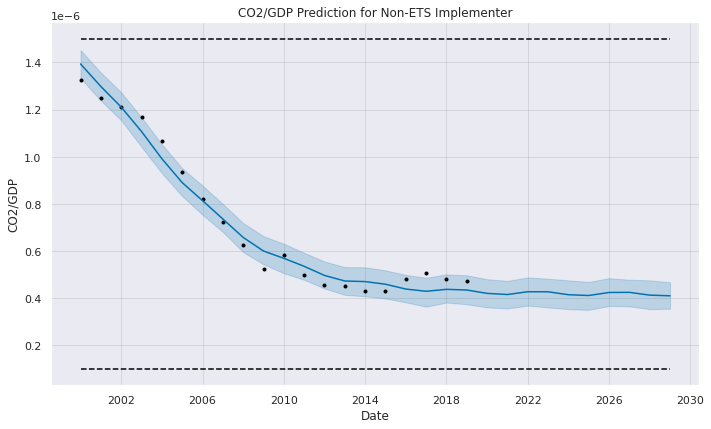

In [22]:
fig_no_ets = m_no_ets.plot(forecast_no_ets, xlabel='Date', ylabel='CO2/GDP')
ax_no_ets = fig_no_ets.gca()
ax_no_ets.set_title("CO2/GDP Prediction for Non-ETS Implementer")
# ax.set_xlabel("X", size=34)
# ax.set_ylabel("Y", size=34)
# ax.tick_params(axis="x", labelsize=24)
# ax.tick_params(axis="y", labelsize=24)
plt.show()

## Conclusions, Assumptions, Overall Analysis

- Dividing the Carbon output by GDP to normalize it works quite well. However, it introduces a new problem, where it seems justified to increase carbon output as long as you have a high GDP.
- Therefore the lower CO2/GDP value might not be caused by the ETS itself but because the nation inherently is more efficient with its carbon emissions because of the high GDP
- There are no significant difference between the change in CO2/GDP between ETS implementer nations and Non-ETS implementer nations